In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import copy
import holidays


In [2]:
# pip install holidays


In [3]:
class DataPreprocessor:
    def __init__(self, df, value_column_name=None):
        """
        Initialize the DataPreprocessor class with the given DataFrame.
        
        Parameters:
        df (pd.DataFrame): The DataFrame containing the dataset.
        value_column_name (str): Column name for the target variable (if working with time series data).
        """
        self.df = df.copy()
        self.value = value_column_name 
        self.numeric_cols = self.df.select_dtypes(include=['float64', 'int64']).columns

    
    # General Data Preprocessing Methods
    def drop_duplicates(self):
        """Drops duplicate rows from the dataset."""
        self.df = self.df.drop_duplicates()
    
    def handle_missing_values(self, strategy='mean'):
        """Handles missing values using the specified strategy (mean, median, most_frequent)."""
        # Impute numerical columns
        if len(self.numeric_cols) > 0:
            numeric_imputer = SimpleImputer(strategy=strategy)
            self.df[self.numeric_cols] = numeric_imputer.fit_transform(self.df[self.numeric_cols])

    def transform_categorical_data(self, categorical_columns):
        """Encodes categorical features using one-hot encoding."""
        encoder = OneHotEncoder(sparse=False, drop='first')
        encoded_data = pd.DataFrame(encoder.fit_transform(self.df[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
        self.df = pd.concat([self.df.drop(categorical_columns, axis=1), encoded_data], axis=1)

    def handle_outliers(self, contamination=0.01):
        """Removes outliers using Isolation Forest."""
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        outliers = iso_forest.fit_predict(self.df[self.numeric_cols])
        self.df = self.df[outliers == 1]
        
    def feature_scaling(self):
        """Scales numerical features using MinMaxScaler (Normalization)."""
        scaler = MinMaxScaler()
        self.df[self.numeric_cols] = scaler.fit_transform(self.df[self.numeric_cols])

    def handle_high_dimensionality(self, num_components=2):
        """Reduces dimensionality using PCA."""
        pca = PCA(n_components=num_components)
        reduced_data = pca.fit_transform(self.df)
        self.df = pd.DataFrame(reduced_data, columns=[f'PC{i}' for i in range(1, num_components + 1)])

    def extract_time_features(self,data_coloumn_name):
        """
        Converts the 'data_coloumn_name' column to datetime format, extracts date and time features,
        and sorts the DataFrame based on the 'data_coloumn_name' column.
        """
        self.df[data_coloumn_name] = pd.to_datetime(self.df[data_coloumn_name], errors='coerce')  
        self.df = self.df.sort_values(by=data_coloumn_name)  

        # Extract various time-related features
        self.df['year'] = self.df[data_coloumn_name].dt.year
        self.df['month'] = self.df[data_coloumn_name].dt.month
        self.df['day'] = self.df[data_coloumn_name].dt.day
        self.df['hour'] = self.df[data_coloumn_name].dt.hour
        
    def get_processed_data(self):
        """Returns the processed DataFrame."""
        return self.df
        




In [4]:
class KMeansOperations:
    def __init__(self, data):
        """
        Initializes the KMeansOperations class.

        Parameters:
        data (DataFrame or ndarray): The input data for clustering.
        """
        self.data = data
        self.kmeans_model = None

    def silhouette_scores(self, min_k=2, max_k=10):
        """
        Finds the optimal number of clusters (k) using the silhouette score
        and visualizes the silhouette scores for each value of k.

        Parameters:
        min_k (int): Minimum number of clusters to try.
        max_k (int): Maximum number of clusters to try.

        Returns:
        int: The optimal number of clusters.
        """
        silhouette_scores = []
        K_range = range(min_k, max_k + 1)

        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(self.data)
            score = silhouette_score(self.data, labels)
            silhouette_scores.append(score)

        # Plot silhouette scores for different k
        plt.figure(figsize=(10, 6))
        sns.lineplot(x=list(K_range), y=silhouette_scores, marker="o")
        plt.title("Silhouette Score for different K")
        plt.xlabel("Number of Clusters (K)")
        plt.ylabel("Silhouette Score")
        plt.grid(True)
        plt.show()

        # Get the best k
        optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
        print(f"Optimal number of clusters (Silhouette Score): {optimal_k}")

        return optimal_k

    def elbow_method(self, min_k=2, max_k=10):
        """
        Finds the optimal number of clusters (k) using the elbow method
        and visualizes the inertia (within-cluster sum of squares) for each value of k.

        Parameters:
        min_k (int): Minimum number of clusters to try.
        max_k (int): Maximum number of clusters to try.

        Returns:
        int: The optimal number of clusters based on the elbow point.
        """
        inertia_scores = []
        K_range = range(min_k, max_k + 1)

        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(self.data)
            inertia_scores.append(kmeans.inertia_)

        # Plot inertia (within-cluster sum of squares) for different k
        plt.figure(figsize=(10, 6))
        sns.lineplot(x=list(K_range), y=inertia_scores, marker="o")
        plt.title("Elbow Method for Optimal K")
        plt.xlabel("Number of Clusters (K)")
        plt.ylabel("Inertia (WCSS)")
        plt.grid(True)
        plt.show()

        optimal_k = self._find_elbow_point(inertia_scores)
        print(f"Optimal number of clusters (Elbow Method): {optimal_k}")

        return optimal_k

    def _find_elbow_point(self, scores):
        """
        Internal method to calculate the elbow point using the second derivative (rate of change).

        Parameters:
        scores (list): List of inertia scores for each k.

        Returns:
        int: The index of the elbow point (optimal k).
        """
        diff1 = np.diff(scores)  # first derivative
        diff2 = np.diff(diff1)  # second derivative
        optimal_k = np.argmax(diff2) + 2  # +2 because of the double diff
        return optimal_k


    def apply_kmeans(self, k):
        """
        Applies KMeans clustering to the data with the specified number of clusters (k).

        Parameters:
        k (int): The number of clusters.

        Returns:
        tuple: A tuple containing:
            - ndarray: Cluster labels for each data point.
            - float: Silhouette score for the clustering.
        """
        self.kmeans_model = KMeans(n_clusters=k, random_state=42)
        labels = self.kmeans_model.fit_predict(self.data)
    
        # Calculate the Silhouette score
        silhouette_avg = silhouette_score(self.data, labels)
    
        return labels, silhouette_avg


    def plot_clusters(self, labels, dim_reduction=None):
        """
        Visualizes clusters using 2D dimensionality reduction (e.g., PCA or t-SNE).

        Parameters:
        labels (ndarray): Cluster labels for each data point.
        dim_reduction (sklearn transformer): A dimensionality reduction method (e.g., PCA, t-SNE).

        Returns:
        None
        """
        if dim_reduction:
            reduced_data = dim_reduction.fit_transform(self.data)
        else:
            # Use first 2 features if no reduction applied
            reduced_data = self.data.iloc[:, :2].values  

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette="Set1")
        plt.title("Cluster Visualization")
        plt.show()

In [5]:
class MyPCA:
    def __init__(self, data):
        """
        Initializes the PCA class with the data.

        Parameters:
        data (ndarray): The input data for PCA.
        """
        self.data = data
        self.pca_model = PCA()  

    def fit(self):
        """Fits the PCA model to the data."""
        self.pca_model.fit(self.data)

    def explained_variance(self):
        """Returns the cumulative explained variance ratio."""
        return np.cumsum(self.pca_model.explained_variance_ratio_)

    def plot_explained_variance(self):
        """Plots the cumulative explained variance ratio."""
        explained_variance_ratio = self.explained_variance()
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
        plt.title('Explained Variance by Number of Principal Components')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.xticks(ticks=np.arange(1, len(explained_variance_ratio) + 1, step=1))  # Set linear tick marks
        plt.grid(True)
        plt.show()

    def get_optimal_components(self, threshold=0.95):
        """
        Gets the optimal number of components based on a cumulative explained variance threshold.

        Parameters:
        threshold (float): The cumulative explained variance threshold (default is 0.95 for 95%).

        Returns:
        int: The optimal number of components.
        """
        explained_variance_ratio = self.explained_variance()
        optimal_k = np.argmax(explained_variance_ratio >= threshold) + 1  # Add 1 for 0-based index
        return optimal_k


In [6]:
def analyze_daily_profile_plot(daily_profile, labels):
    """
    Analyzes daily energy consumption profiles by cluster and plots the average profiles.

    Parameters:
    - daily_profile (DataFrame): The original daily energy profile data.
    - labels (ndarray): Cluster labels for each data point.

    Returns:
    - cluster_analysis (DataFrame): Average energy consumption per cluster.
    """
    # Create a deep copy of the daily profile to avoid modifying the original data
    daily_profile_analysis = copy.deepcopy(daily_profile)
    daily_profile_analysis['Cluster'] = labels

    # Analyze each cluster by calculating the mean energy consumption
    cluster_analysis = daily_profile_analysis.groupby('Cluster').mean()  # Average profile per cluster

    hours = np.arange(24)  # Define hours of the day

    # Plot the average daily load profiles for each cluster
    plt.figure(figsize=(12, 6))
    for cluster in cluster_analysis.index:
        # Make sure to slice the correct number of columns
        plt.plot(hours, cluster_analysis.loc[cluster].values, label=f'Cluster {cluster}')
    
    plt.title('Average Daily Energy Consumption Profiles by Cluster')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Energy Consumption (Megawatt)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

    return cluster_analysis

1. **Data Preparation**:
   - Load the dataset and extract relevant columns (e.g., `Datetime`, `Megawatt Energy Consumption`)..

In [8]:
data_path = 'Clustering Daily Energy Consumption/AEP_hourly.csv' 


In [9]:
# Load the dataset
df = pd.read_csv(data_path, parse_dates=['Datetime'])

# Filter AEP data
df_profile = copy.deepcopy(df[['Datetime', 'AEP_MW']])
df_profile.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


2. **Feature Engineering**:
   - Create a pivot table where each row represents a day, and each column represents the hourly energy consumption for that day (24 hours as columns).
   

In [11]:
# Extract date and hour
df_profile['Date'] = df_profile['Datetime'].dt.date
df_profile['Hour'] = df_profile['Datetime'].dt.hour

# Pivot to have days as rows and hours as columns
daily_profile = df_profile.pivot_table(index='Date', columns='Hour', values='AEP_MW')

3. **Data Normalization and preprocessing**:
- Handle any missing data by filling or interpolating values.
- Scale the data to ensure that differences in magnitude (e.g., between peak and low consumption hours) do not affect clustering.
.

In [13]:
preprocessor = DataPreprocessor(daily_profile, value_column_name='AEP_MW')
preprocessor.drop_duplicates()
preprocessor.handle_missing_values()
preprocessor.handle_outliers()
preprocessor.feature_scaling()


In [14]:
daily_profile=preprocessor.get_processed_data()
daily_profile.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-01,0.384735,0.213660,0.191485,0.176312,0.174254,0.181304,0.226565,0.321233,0.355142,0.354006,...,0.307013,0.366130,0.373755,0.366800,0.331372,0.306629,0.317675,0.327829,0.293927,0.251116
2004-10-02,0.233878,0.202213,0.166380,0.144728,0.135937,0.132902,0.142642,0.174259,0.183011,0.209897,...,0.188225,0.215621,0.215583,0.222167,0.192090,0.176642,0.202444,0.218327,0.222106,0.150473
2004-10-03,0.136095,0.123617,0.083811,0.074872,0.068516,0.068966,0.069950,0.088055,0.098218,0.113305,...,0.118512,0.139720,0.144259,0.160354,0.140846,0.145225,0.201945,0.233655,0.210135,0.167619
2004-10-04,0.154047,0.159596,0.141180,0.136275,0.142323,0.157328,0.226831,0.334916,0.374122,0.365722,...,0.317228,0.366738,0.370094,0.364871,0.337926,0.332862,0.375790,0.394224,0.359109,0.289516
2004-10-05,0.259753,0.228379,0.209717,0.198049,0.203175,0.210848,0.269897,0.377656,0.418872,0.406767,...,0.292863,0.329661,0.327475,0.327998,0.303888,0.302074,0.354090,0.383554,0.349148,0.291570


4. **Clustering with K-Means**:
   - Apply the K-means clustering algorithm to identify different energy consumption profiles.
   - Experiment with different numbers of clusters (e.g., 2–5) and use the silhouette score to evaluate the optimal number of clusters.

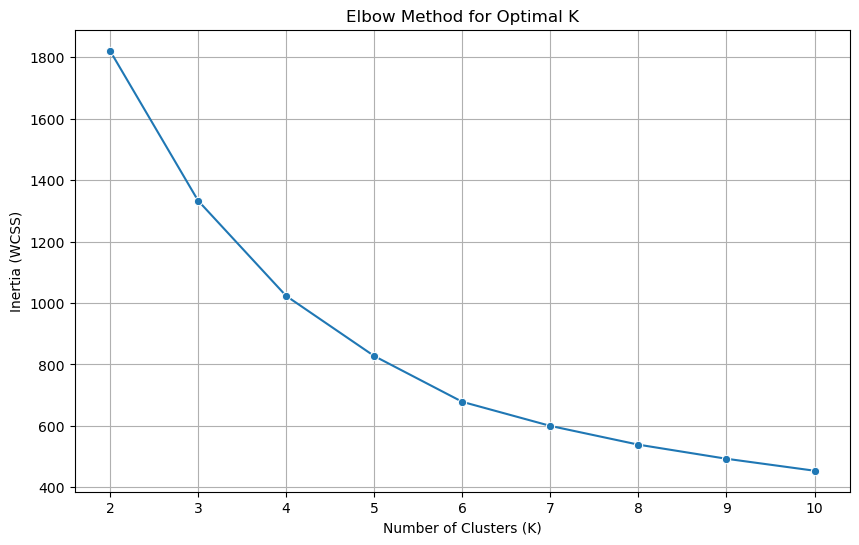

Optimal number of clusters (Elbow Method): 2


In [16]:
kmeans_ops = KMeansOperations(daily_profile)
# Find optimal k using the elbow method
optimal_k_elbow = kmeans_ops.elbow_method(min_k=2, max_k=10)


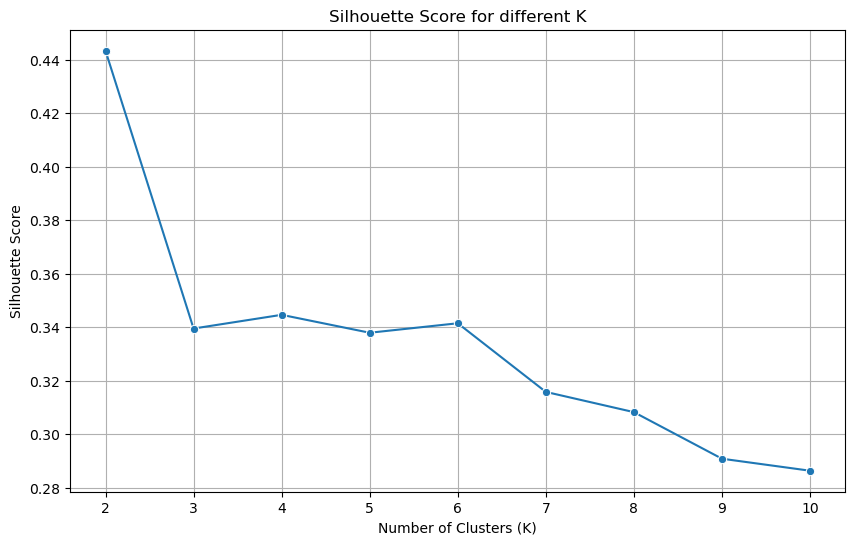

Optimal number of clusters (Silhouette Score): 2


In [17]:
kmeans_ops = KMeansOperations(daily_profile)

# Find optimal k using silhouette scores
optimal_k_silhouette = kmeans_ops.silhouette_scores(min_k=2, max_k=10)


In [18]:
labels,silhouette_avg=kmeans_ops.apply_kmeans(2)
print(f"the silhouetter score is {silhouette_avg}")


the silhouetter score is 0.4433632619289098



5. **Visualization**:
   - Plot the daily load profiles in a 2D plane using t-SNE or PCA to visualize how well the data is clustered.

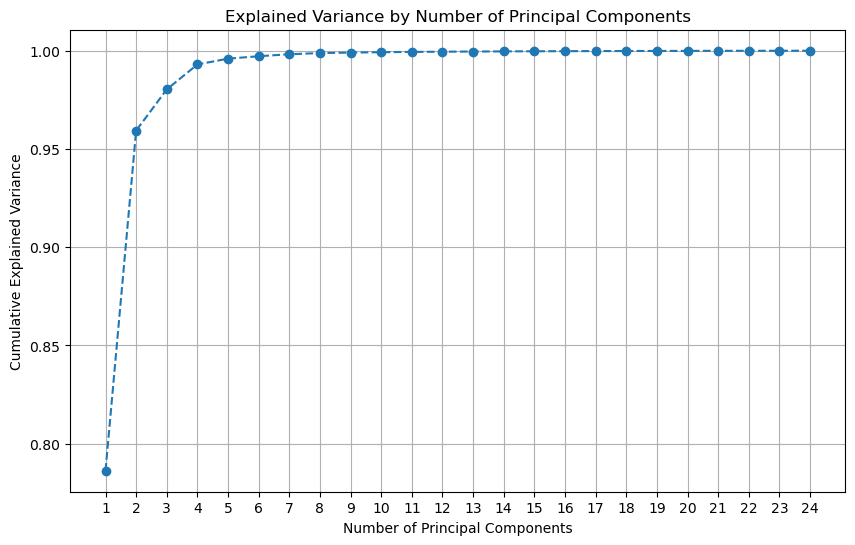

Optimal number of components for 95% explained variance: 2


In [20]:
pca = MyPCA(daily_profile)

# Fit the PCA model
pca.fit()

# Plot the explained variance
pca.plot_explained_variance()

# Get the optimal number of components for 95% explained variance
optimal_components = pca.get_optimal_components(threshold=0.95)
print(f"Optimal number of components for 95% explained variance: {optimal_components}")

In [21]:
preprocessor.handle_high_dimensionality(2)
daily_profile_pca=preprocessor.get_processed_data()
daily_profile_pca.head()

,PC1,PC2
0,-0.481255,0.033256
1,-0.998926,-0.057050
2,-1.317355,0.008942
3,-0.488711,0.110199
4,-0.417317,-0.066940


In [22]:
kmeans_ops = KMeansOperations(daily_profile_pca)
labels,silhouette_avg=kmeans_ops.apply_kmeans(2)
print(f"the silhouetter score is {silhouette_avg}")

the silhouetter score is 0.46975804588173864


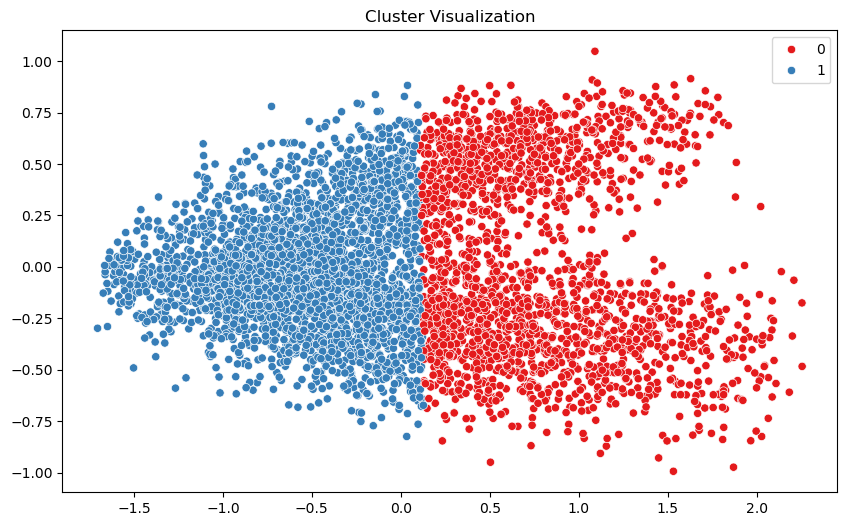

In [23]:
kmeans_ops.plot_clusters(labels)

### Try different k : for example k=3 and k=4 and make them analysis
maybe can define as 3 categories low , mid and high use

the silhouetter score is 0.3751351253269399


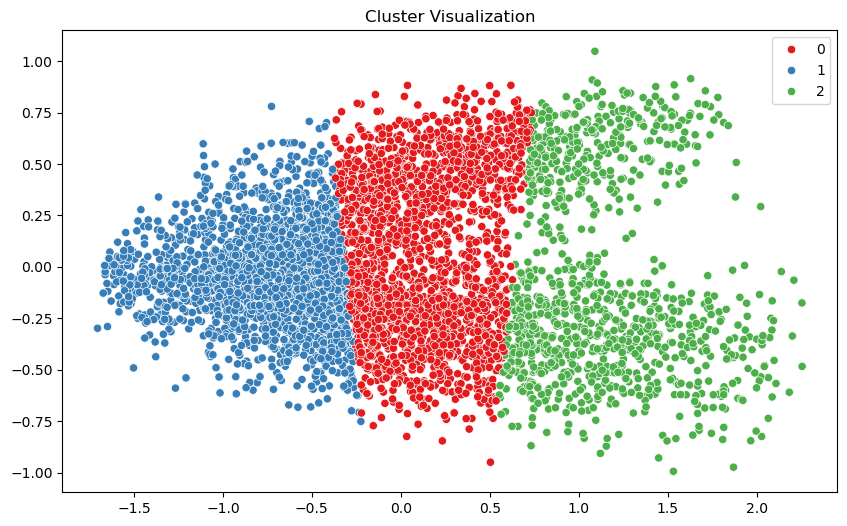

In [25]:
kmeans_ops_3 = KMeansOperations(daily_profile_pca)
labels_3,silhouette_avg_3=kmeans_ops_3.apply_kmeans(3)
print(f"the silhouetter score is {silhouette_avg_3}")
kmeans_ops.plot_clusters(labels_3)

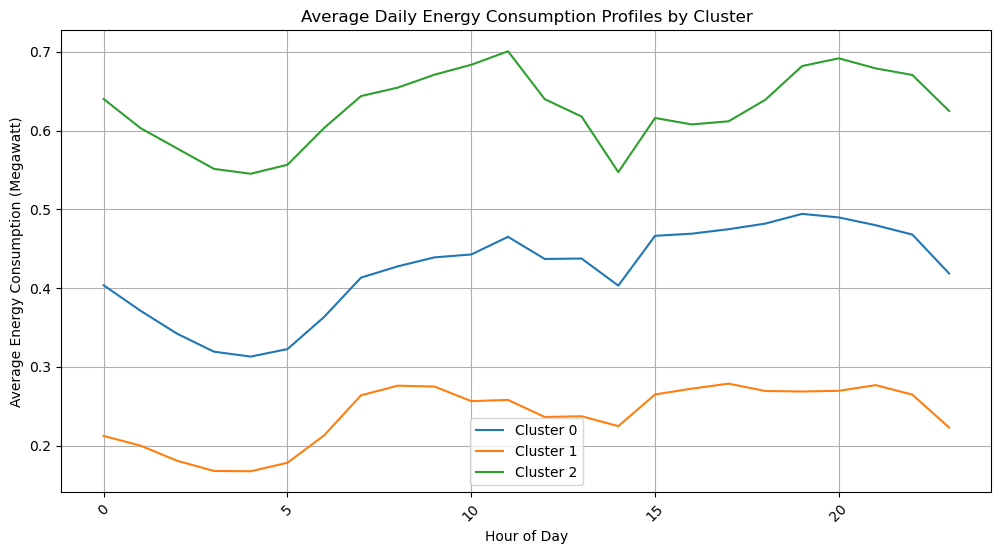

In [26]:
daily_profile_analysis_3=analyze_daily_profile_plot(daily_profile, labels_3)

### can not interpret the result

the silhouetter score is 0.38646380551212695


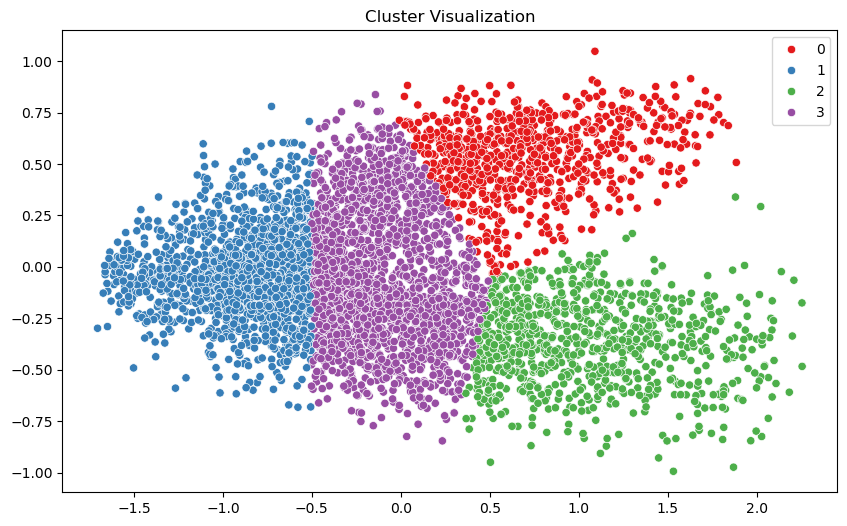

In [28]:
kmeans_ops_4 = KMeansOperations(daily_profile_pca)
labels_4,silhouette_avg_4=kmeans_ops_4.apply_kmeans(4)
print(f"the silhouetter score is {silhouette_avg_4}")
kmeans_ops.plot_clusters(labels_4)

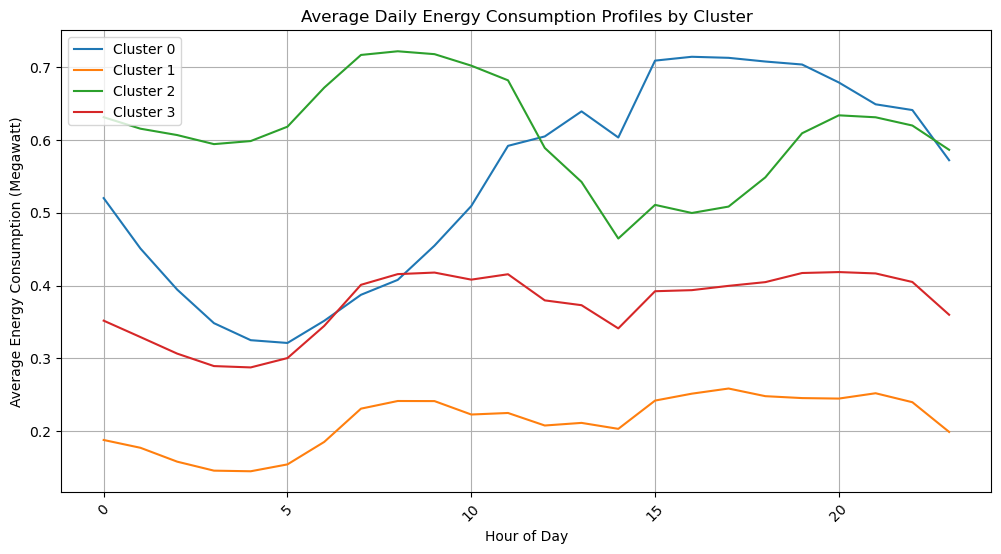

In [29]:
daily_profile_analysis_4=analyze_daily_profile_plot(daily_profile, labels_4)

6. **Optional Extensions**:
   - Apply different clustering algorithms to see if they perform better than K-means (e.g., DBSCAN or Agglomerative Clustering).

In [31]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(daily_profile)

# Calculate the Silhouette score
# Note: DBSCAN can produce -1 labels for noise points, so we need to filter them out
if len(set(dbscan_clusters)) > 1:  # Ensure there is more than one cluster
    silhouette_avg = silhouette_score(daily_profile, dbscan_clusters)
else:
    silhouette_avg = -1  # Assign -1 if there is only one cluster or all points are noise

print(f"The silhouette score for DBSCAN is {silhouette_avg}")


The silhouette score for DBSCAN is 0.23753960027544205


#### the DBSCAN has poor silhouette score which can be due the poor hyper parameters , let's try to fine tuning them
 After fine tuning , the DCAN has a lower silhouette score in compare to the kmeans , which means the kmeans has a better preformance in this case

In [33]:

def find_best_dbscan_params(data):
    best_score = -1
    best_eps = None
    best_min_samples = None
    
    eps_values = np.arange(0.1, 1.5, 0.1)  
    min_samples_values = range(2, 20)      
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            if len(set(labels)) > 1:  # Check if at least two clusters are found
                score = silhouette_score(data, labels)
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples
                    
    return best_eps, best_min_samples, best_score

best_eps, best_min_samples, best_score = find_best_dbscan_params(daily_profile)
print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_score}")


Best eps: 0.7000000000000001, Best min_samples: 2, Best Silhouette Score: 0.36559572578984667


### 7. **Analysis**: for the best k 2
   - Interpret the resulting clusters 

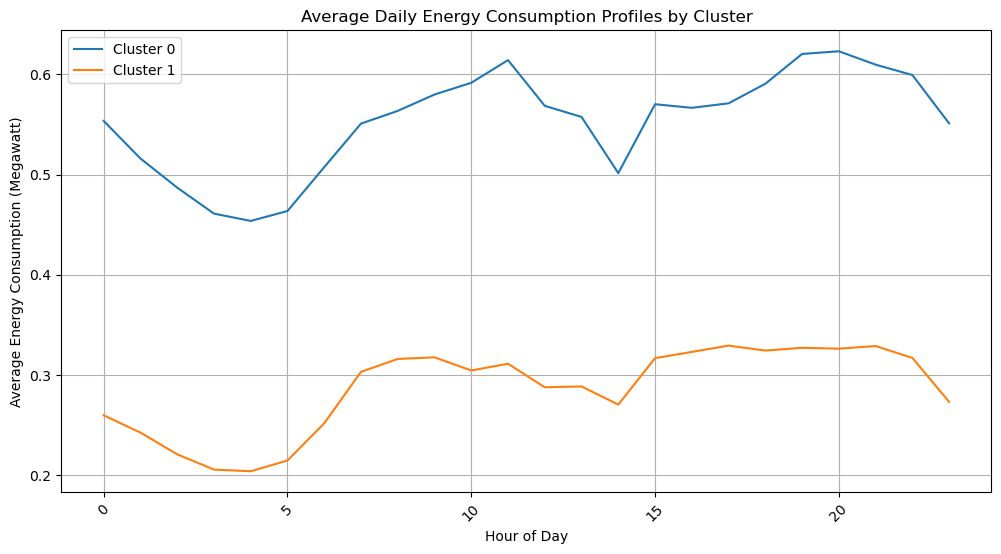

In [35]:
daily_profile_analysis=analyze_daily_profile_plot(daily_profile, labels)

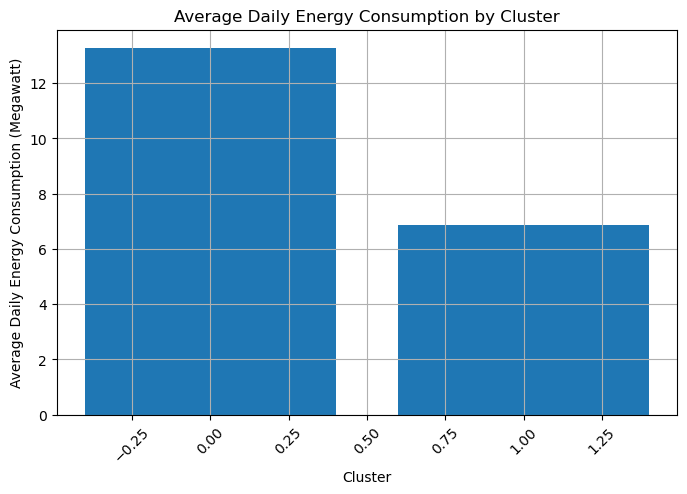

In [36]:
# Calculate total daily consumption
daily_profile_analysis['Total_Consumption'] = daily_profile_analysis.sum(axis=1)  # Sum across hourly columns

# Average daily consumption for each cluster
avg_daily_consumption = daily_profile_analysis.groupby('Cluster')['Total_Consumption'].mean().reset_index()

# Plotting average daily consumption for each cluster
plt.figure(figsize=(8, 5))
plt.bar(avg_daily_consumption['Cluster'], avg_daily_consumption['Total_Consumption'])
plt.title('Average Daily Energy Consumption by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Daily Energy Consumption (Megawatt)')
plt.xticks(rotation=45)
plt.grid()
plt.show()


##### the result from the analysis :
Cluster 0:
This cluster represents high energy usage during peak hours


Cluster1:
This cluster represents low energy usage throughout the day.

# data insights
### Holidays vs Weekdays
first we want to compare the energy consumption in Holiday vs weekdays , so we need to extract the holidays first

In [39]:
df = pd.read_csv(data_path, parse_dates=['Datetime'])
preprocessor = DataPreprocessor(df, value_column_name='AEP_MW')
preprocessor.drop_duplicates()
preprocessor.handle_missing_values()
preprocessor.handle_outliers()
preprocessor.feature_scaling()
preprocessor.extract_time_features("Datetime")
df=preprocessor.get_processed_data()
df['Datetime'] = df['Datetime'].dt.date
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df.set_index('Datetime', inplace=True)
df.head()

,AEP_MW,year,month,day,hour
Datetime,,,,,
2004-10-01,0.176082,2004,10,1,1
2004-10-01,0.139464,2004,10,1,2
2004-10-01,0.119423,2004,10,1,3
2004-10-01,0.111588,2004,10,1,4
2004-10-01,0.118515,2004,10,1,5


In [40]:
# Automatically get holidays for a specific country (e.g., United States)
us_holidays = holidays.UnitedStates(years=df['year'].unique())
# Create a DataFrame for the holidays
holiday_dates = pd.DataFrame(list(us_holidays.keys()), columns=['Date'])
holiday_dates['is_holiday'] = True
# Convert 'Datetime' column to datetime
holiday_dates['Date'] = pd.to_datetime(holiday_dates['Date'], errors='coerce')
holiday_dates.set_index('Date', inplace=True)
df = pd.merge(df, holiday_dates, left_index=True, right_index=True, how='left')
df['is_holiday'] = df['is_holiday'].where(df['is_holiday'].notna(), False)
df.head()

,AEP_MW,year,month,day,hour,is_holiday
Datetime,,,,,,
2004-10-01,0.176082,2004,10,1,1,False
2004-10-01,0.139464,2004,10,1,2,False
2004-10-01,0.119423,2004,10,1,3,False
2004-10-01,0.111588,2004,10,1,4,False
2004-10-01,0.118515,2004,10,1,5,False


The average of use in  weekdays is greater that the holidays ,where energy usage tends to increase during weekdays due to higher industrial, commercial, and residential activities

In [42]:
# Calculate the average AEP_MW for holidays and non-holidays
average_aep = df.groupby('is_holiday')['AEP_MW'].mean().reset_index()

# Rename columns for clarity
average_aep.columns = ['is_holiday', 'average_AEP_MW']

# Display the results
print(average_aep)

   is_holiday  average_AEP_MW
0       False        0.431719
1        True        0.396524


### ploting the average monthes using per year 
The analysis indicates that January, December, July, and August consistently exhibit the highest power consumption rates across most years. This trend suggests a strong correlation between weather conditions and energy usage, highlighting the impact of seasonal variations on power consumption.

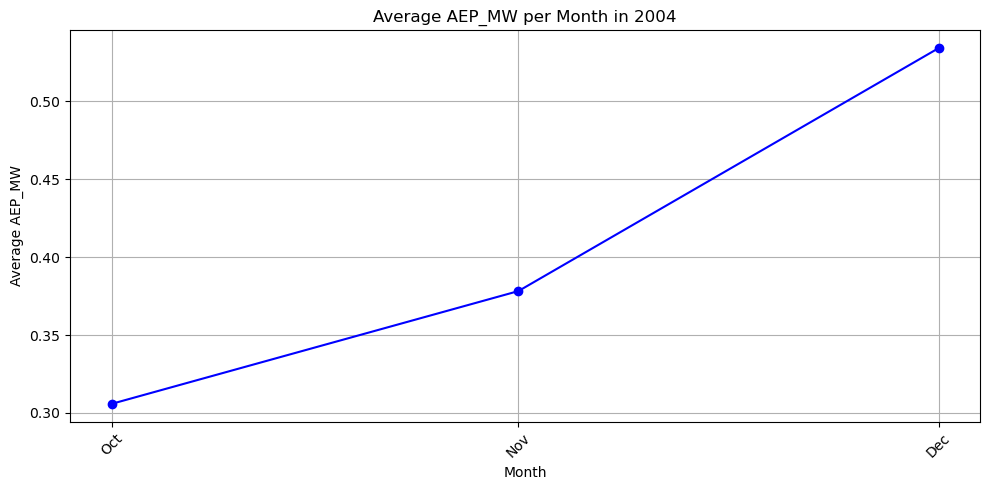

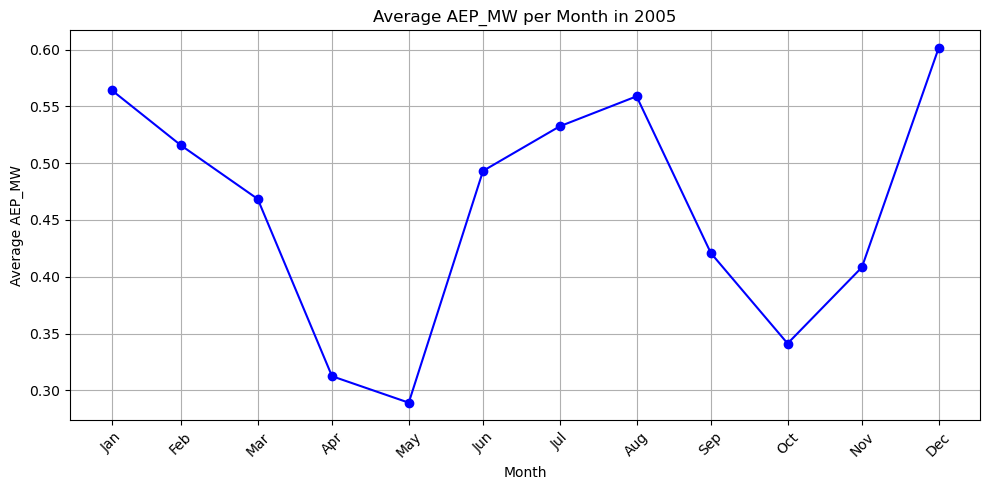

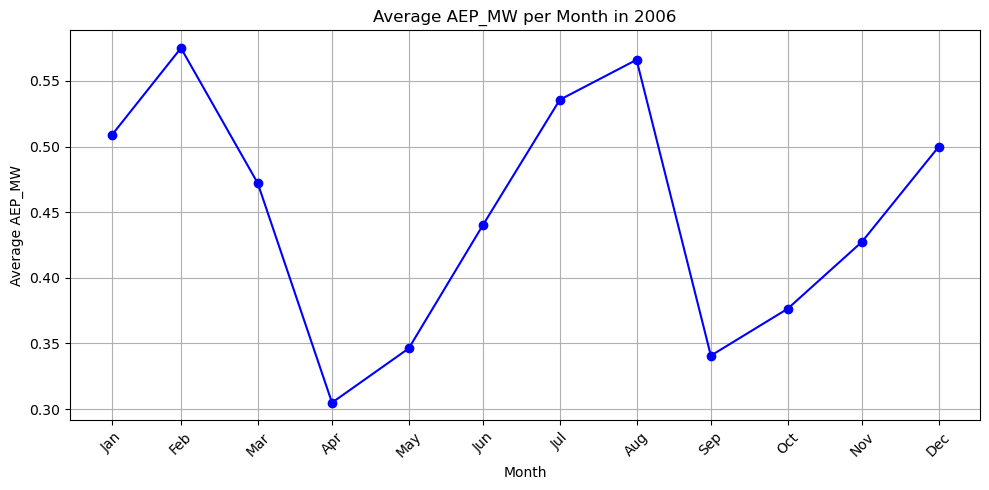

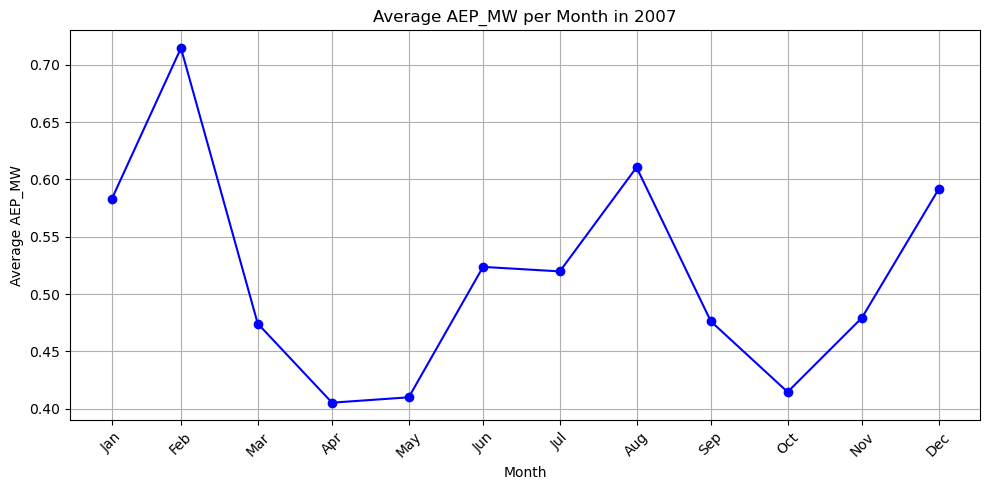

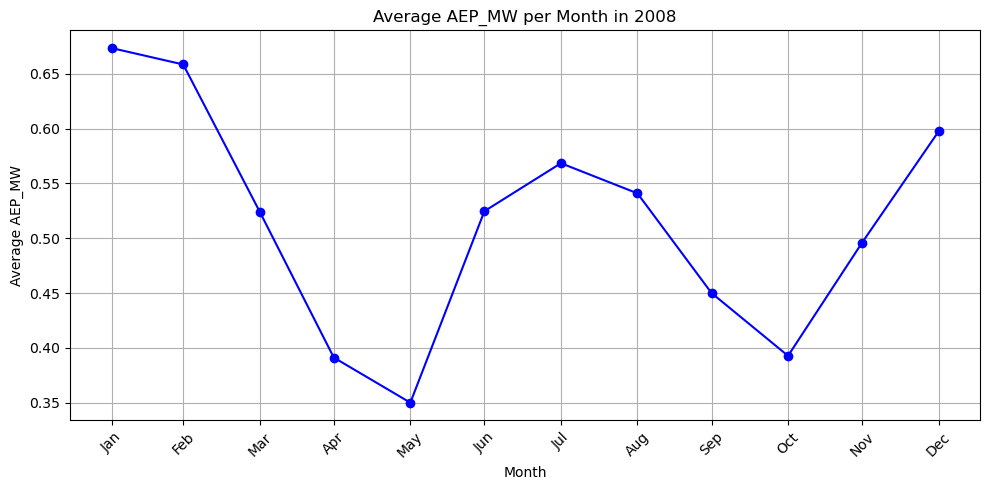

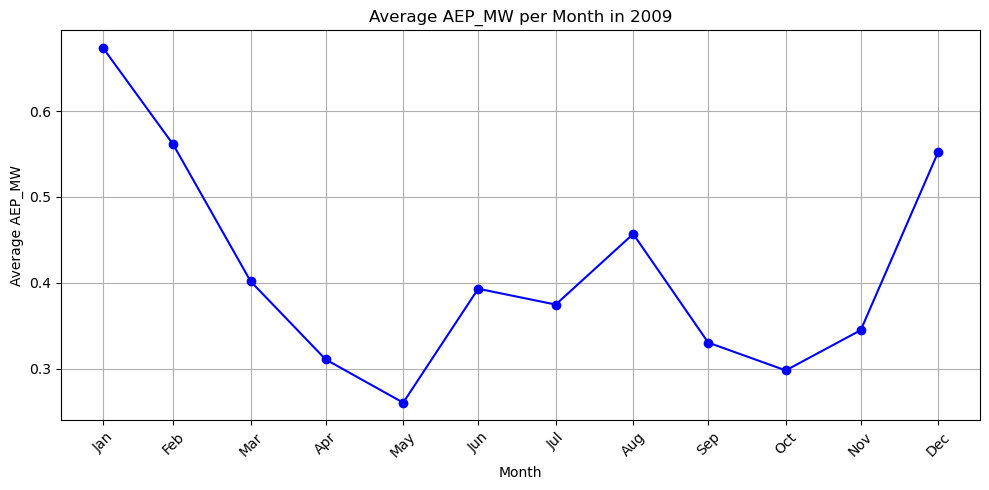

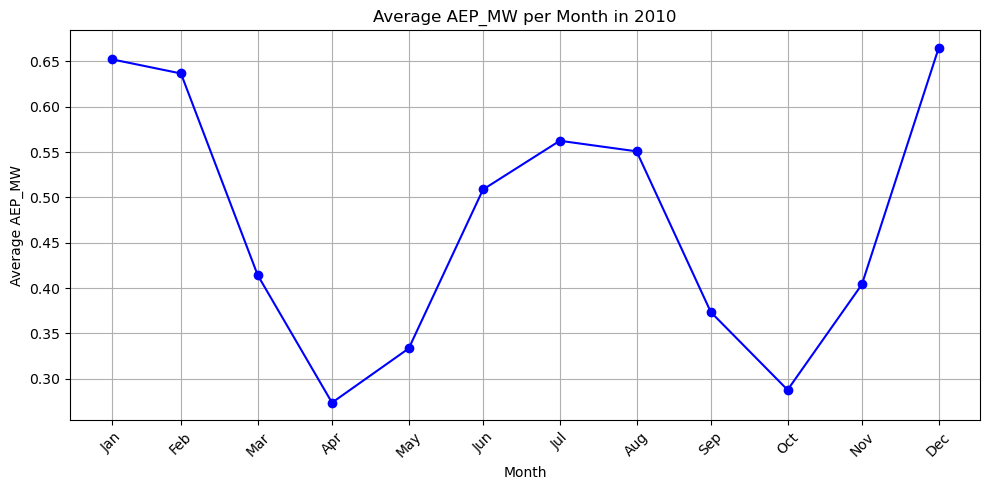

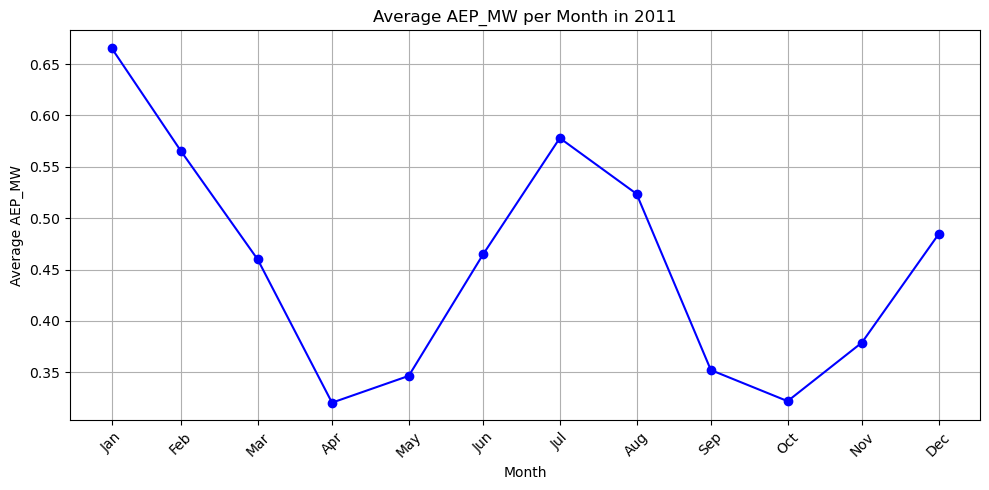

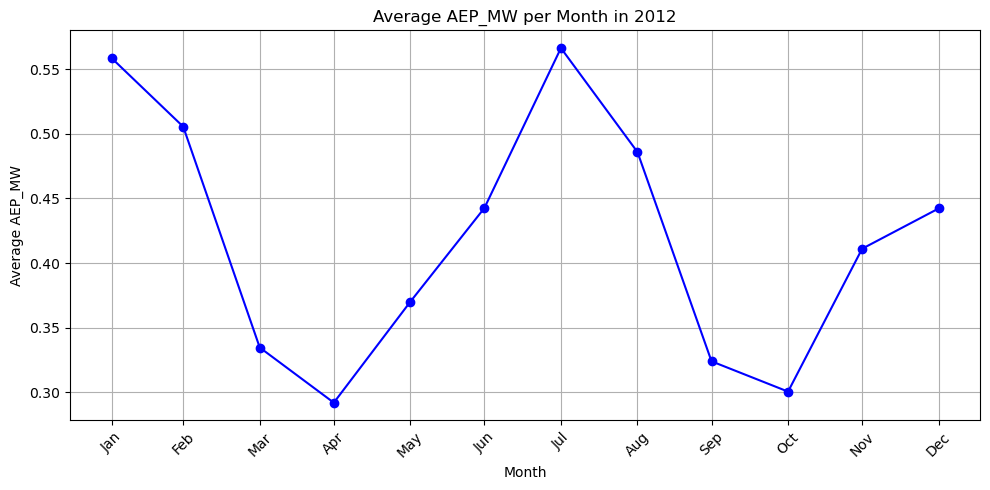

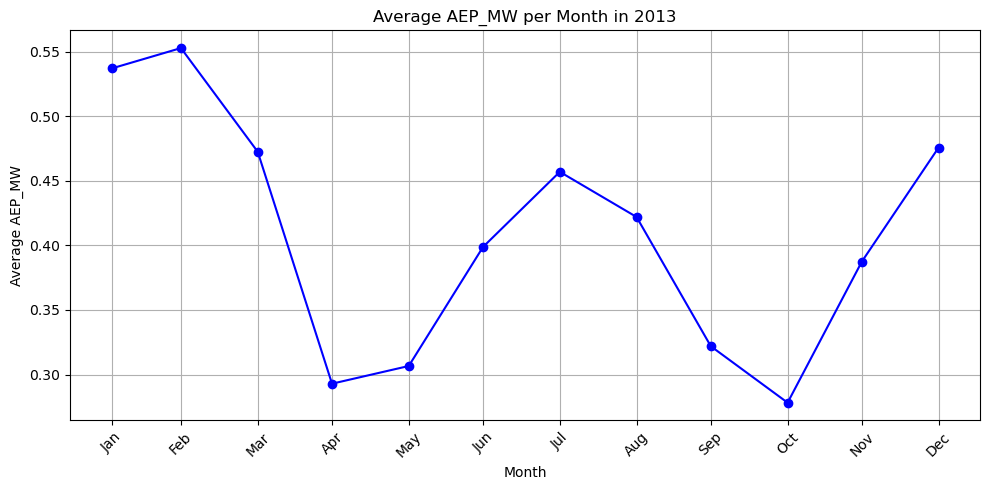

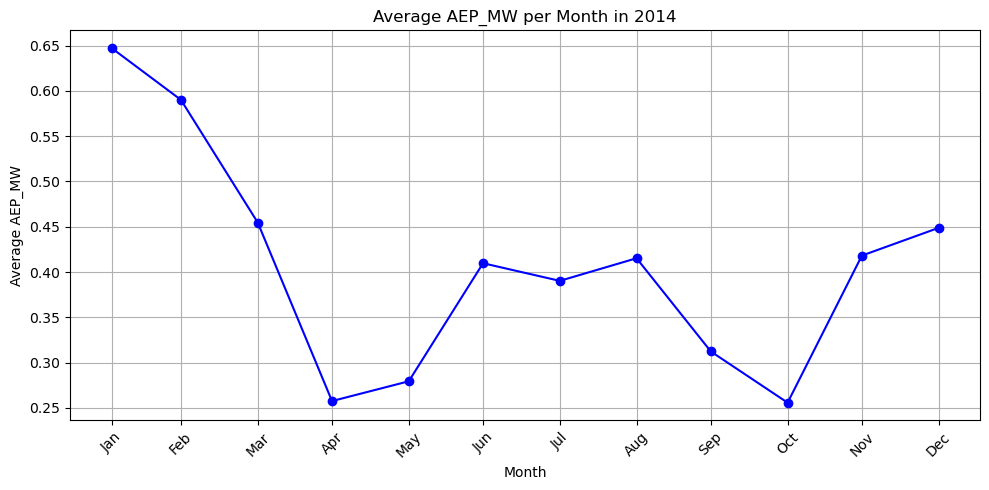

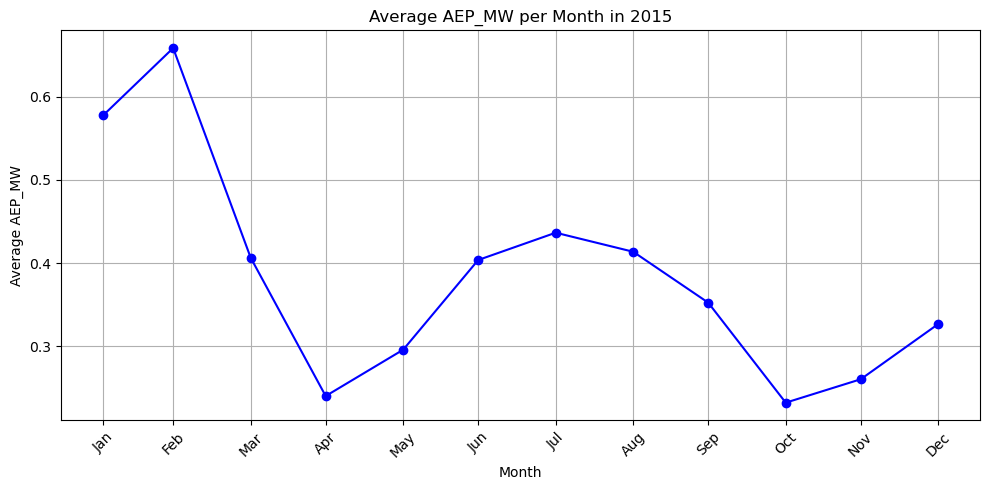

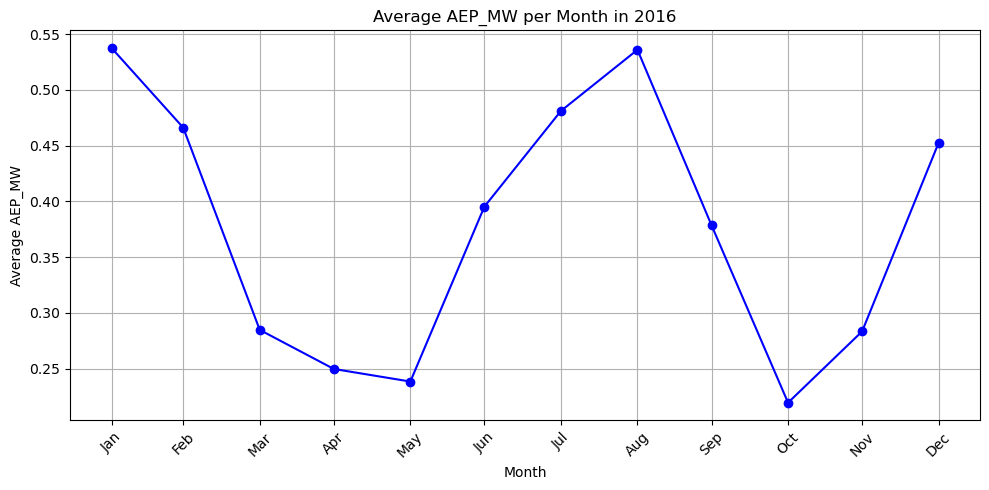

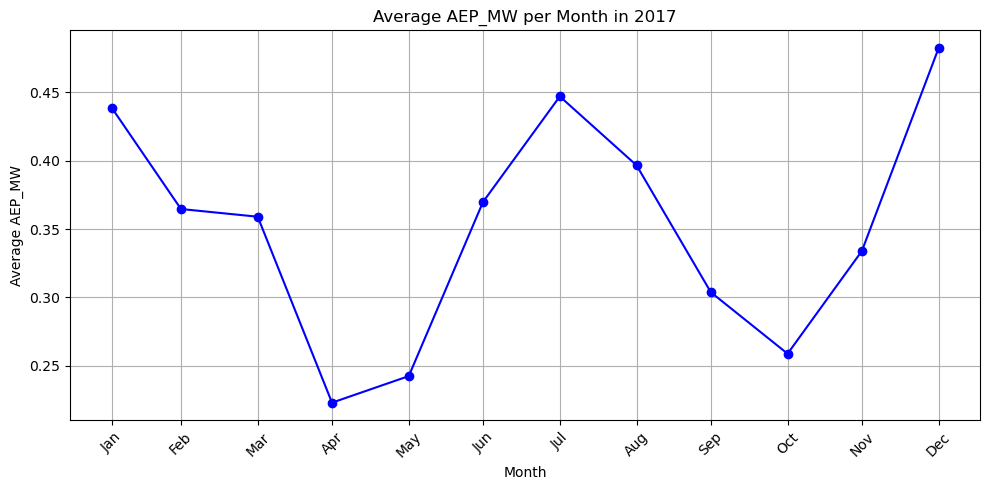

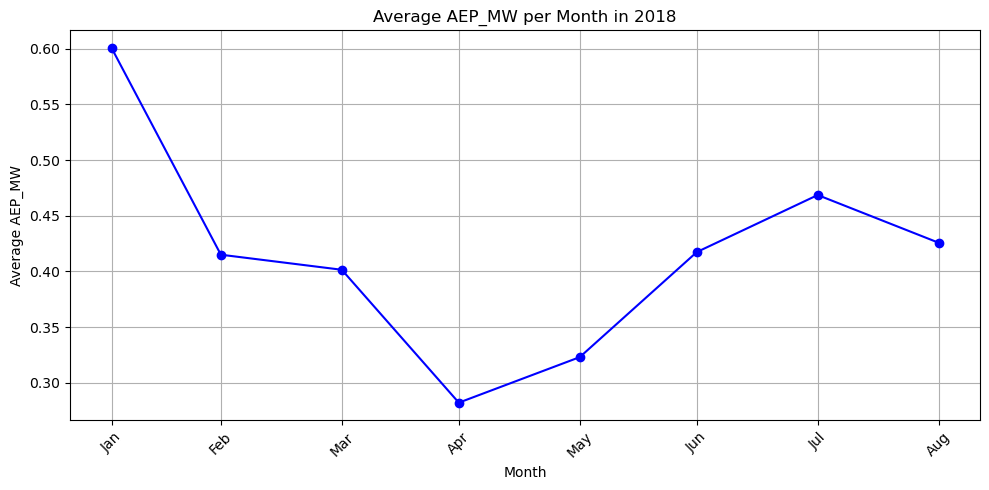

In [44]:
# Resample to get the monthly average of AEP_MW
monthly_avg = df['AEP_MW'].resample('ME').mean()

# Extract year for grouping
monthly_avg = monthly_avg.to_frame(name='AEP_MW')
monthly_avg['Year'] = monthly_avg.index.year

# Plotting
years = monthly_avg['Year'].unique()

for year in years:
    plt.figure(figsize=(10, 5))
    monthly_data = monthly_avg[monthly_avg['Year'] == year]
    
    plt.plot(monthly_data.index, monthly_data['AEP_MW'], marker='o', linestyle='-', color='b')
    plt.title(f'Average AEP_MW per Month in {year}')
    plt.xlabel('Month')
    plt.ylabel('Average AEP_MW')
    plt.xticks(monthly_data.index, [date.strftime('%b') for date in monthly_data.index], rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

### Plot the Average Energy Usage per Year
(Note: Not all years are included as some years do not have complete data for fair comparison.)

In 2009, power consumption reached its lowest point after peaking in 2008. This decline was followed by a slight increase in 2010, but energy consumption continued to decrease thereafter. 

The 2009 recession significantly affected all economic sectors in the EU, leading to reduced energy demand and underscoring the relationship between economic activity and energy consumption. Additionally, the period following 2010 saw an increased awareness of energy consumption, driving efforts toward energy efficiency and conservation. 

This awareness is likely influencing ongoing trends in energy use, as individuals and organizations seek to optimize their consumption in response to economic and environmental considerations.


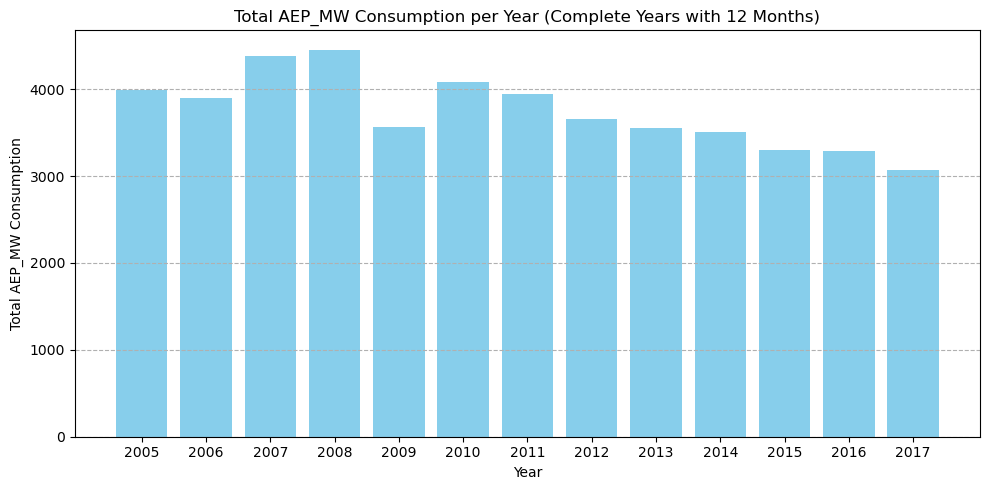

In [46]:
# Group by year and count unique months
months_count = df.groupby('year')['month'].nunique()

# Filter years that have 12 unique months
complete_years = months_count[months_count == 12].index

#  Calculate total consumption for complete years
total_consumption_per_year = df.groupby('year')['AEP_MW'].sum()
filtered_consumption = total_consumption_per_year[total_consumption_per_year.index.isin(complete_years)]

# Plotting the variable chart (bar chart)
plt.figure(figsize=(10, 5))
plt.bar(filtered_consumption.index, filtered_consumption, color='skyblue')
plt.title('Total AEP_MW Consumption per Year (Complete Years with 12 Months)')
plt.xlabel('Year')
plt.ylabel('Total AEP_MW Consumption')
plt.xticks(filtered_consumption.index)  
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

### Plot the average Energy Consumption per hour
The analysis of hourly energy consumption reveals that the highest usage occurs between the hours of 19:00 and 21:00. This peak in consumption during the evening hours is indicative of increased demand for electricity, likely due to activities such as cooking, heating, and lighting in households as people return home from work. 


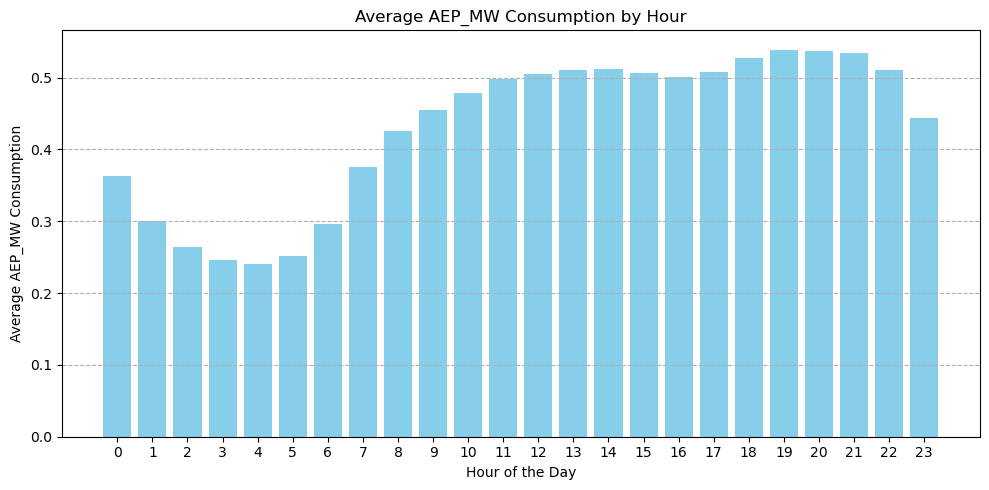

In [48]:
# Calculate average AEP_MW by hour
average_AEP_MW_by_hour = df.groupby('hour')['AEP_MW'].mean()

# Plotting the variable chart (bar chart)
plt.figure(figsize=(10, 5))
plt.bar(average_AEP_MW_by_hour.index, average_AEP_MW_by_hour, color='skyblue')
plt.title('Average AEP_MW Consumption by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average AEP_MW Consumption')
plt.xticks(average_AEP_MW_by_hour.index)  # Set x-ticks to hours
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

### Plotting the Average Energy Use in Every Time Interval

The analysis of energy consumption across different time intervals indicates that usage is maximized during the afternoon and evening periods. This trend suggests that energy demand peaks when people are most active, particularly in the hours following work and school.


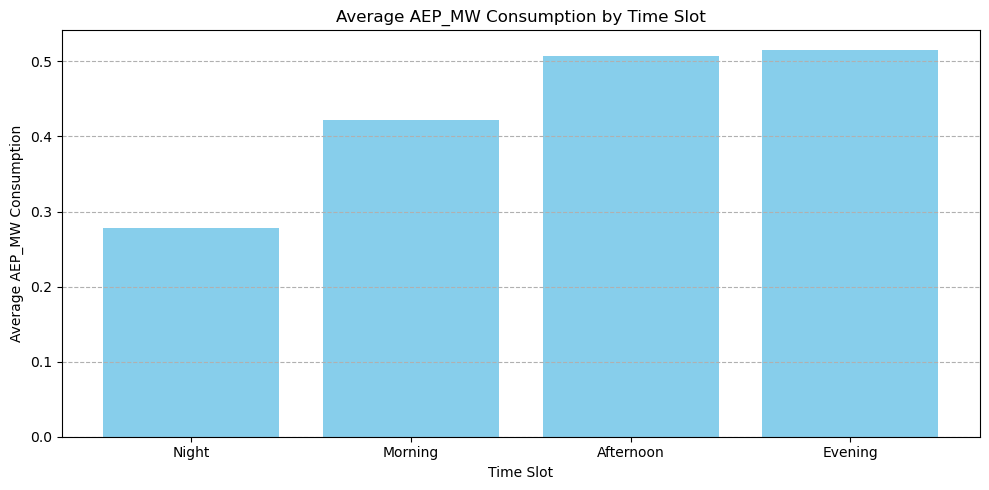

Average AEP_MW Consumption during Night: 0.28 MW
Average AEP_MW Consumption during Morning: 0.42 MW
Average AEP_MW Consumption during Afternoon: 0.51 MW
Average AEP_MW Consumption during Evening: 0.52 MW


In [50]:
#  Categorize hours into time slots and calculate averages
time_slots = {
    'Night': average_AEP_MW_by_hour.loc[0:5].mean(),  # 12 AM - 5 AM
    'Morning': average_AEP_MW_by_hour.loc[6:11].mean(),  # 6 AM - 11 AM
    'Afternoon': average_AEP_MW_by_hour.loc[12:17].mean(),  # 12 PM - 5 PM
    'Evening': average_AEP_MW_by_hour.loc[18:23].mean()   # 6 PM - 11 PM
}

# Convert to DataFrame for easier plotting
time_slots_df = pd.DataFrame(list(time_slots.items()), columns=['Time Slot', 'Average AEP_MW'])

#  Plotting the variable chart (bar chart)
plt.figure(figsize=(10, 5))
plt.bar(time_slots_df['Time Slot'], time_slots_df['Average AEP_MW'], color='skyblue')
plt.title('Average AEP_MW Consumption by Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Average AEP_MW Consumption')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Print the averages for each time slot
for slot, avg in time_slots.items():
    print(f'Average AEP_MW Consumption during {slot}: {avg:.2f} MW')

### Solutions:

1. To manage peak energy demand during afternoon and evening hours, utilities can implement time-based pricing to encourage users to shift their consumption to off-peak times

2. Enhancing energy efficiency initiatives, such as promoting smart home technologies, can significantly lower overall consumption during pe hours.